In [1]:
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
import sys
sys.path.append("../chembl_analyser/module/")
from calcula_tanimoto import *

In [3]:
from ddc_pub import ddc_v3 as ddc

In [4]:
import molvecgen

In [5]:
model_name = "models/pcb_model"
model = ddc.DDC(model_name=model_name)

Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.


/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading finished in 1 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 256), (None, 18432       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      1364771     Decoder_Inputs[0][0]             
                                                               

In [6]:
qsar_model_name = "models/qsar_model.pickle"
with open(qsar_model_name, "rb") as file:
    qsar_model = pickle.load(file)["classifier_sv"]

/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#We suppres stdout from invalid smiles and validations
from rdkit import rdBase
rdBase.DisableLog ( 'rdApp.*')

In [8]:
def get_descriptors(mol):
    logp  = Descriptors.MolLogP(mol)
    tpsa  = Descriptors.TPSA(mol)
    molwt = Descriptors.ExactMolWt(mol)
    hba   = rdMolDescriptors.CalcNumHBA(mol)
    hbd   = rdMolDescriptors.CalcNumHBD(mol)
    qed   = QED.qed(mol)
     
                     
    # Calculate fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)
    ecfp4 = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, ecfp4) 
    # Predict activity and pick only the second component
    active_probability = qsar_model.predict_proba([ecfp4])[0][1]
    return [logp, tpsa, molwt, qed, hba, hbd, active_probability]

In [9]:
smiles_target = "C=C[C@](C)(O)CCC=C(C)C"

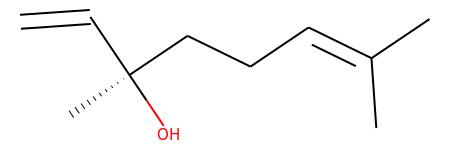

[2.6698000000000013,
 20.23,
 154.135765196,
 0.6171290071333284,
 1,
 1,
 2.8304322844892562e-05]

In [10]:
mol = Chem.MolFromSmiles(smiles_target)
display(mol)
conditions = get_descriptors(mol)
conditions

In [11]:
target = np.array(conditions)
#smiles_out, _ = model.predict(latent=target, temp=1)
#Chem.MolFromSmiles(smiles_out)

In [12]:
#model.batch_input_length = 256
smiles_out = []
for i in range(100):
    smiles, _ = model.predict_batch(latent=target.reshape(1,-1), temp=1.0)
    smiles_out.append(smiles)
smiles_out = np.concatenate(smiles_out)
smiles_out.shape

/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log

/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/home/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log

(25600,)

In [13]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

In [14]:
def sanitize(mol):
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(e)
         
sani_mols = [sanitize(mol) for mol in mols if mol != None]

Sanitization error: Explicit valence for atom # 7 O, 5, is greater than permitted


In [15]:
len(sani_mols)

24282

In [16]:
len(sani_mols)/len(smiles_out)

0.948515625

In [19]:
properties = [[Chem.MolToSmiles(mol)] + get_descriptors(mol) for mol in sani_mols if mol != None]
import pandas as pd
target_names = ["Smiles", "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"]
data = pd.DataFrame(properties, columns=target_names)

In [20]:
data.sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
24161,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
18214,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
16492,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
17423,CC1CCc2cc(O)ccc21,2.44190,20.23000,148.08882,0.59877,1,1,0.69450
10657,CC1CCc2cc(O)ccc21,2.44190,20.23000,148.08882,0.59877,1,1,0.69450
...,...,...,...,...,...,...,...,...
84,CCC(=O)Nc1ccccc1,2.03510,29.10000,149.08406,0.68451,1,1,0.00000
11814,CCC(=O)Nc1ccccc1,2.03510,29.10000,149.08406,0.68451,1,1,0.00000
279,CC(=O)Nc1ccsc1C,2.01492,29.10000,155.04048,0.66006,2,1,0.00000
24033,CC(=O)Nc1ccccc1C,1.95342,29.10000,149.08406,0.64929,1,1,0.00000


In [21]:
len(data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False))

31

In [22]:
data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
144,CCCC#CC1=CCC(O)C1,1.87100,20.23000,150.10447,0.56566,1,1,0.08220
8986,[C-]#[N+]c1cccc(NCCC)c1,3.05929,16.39000,160.10005,0.67201,1,1,0.02016
18090,[C-]#[N+]c1cccc(NCCC)c1,3.05929,16.39000,160.10005,0.67201,1,1,0.02016
22257,C=C(C)C#Cc1cccc(O)c1,2.31980,20.23000,158.07316,0.57434,1,1,0.01435
191,C#CCCCC1(C)CCC1O,1.95090,20.23000,152.12012,0.48384,1,1,0.00542
15210,CC#CC=Cc1ccc(O)cc1,2.42870,20.23000,158.07316,0.62217,1,1,0.00071
12698,C#CC=CC1CCCC1(C)O,1.72690,20.23000,150.10447,0.56426,1,1,0.00066
2997,CC(C)CC#CCC(C)C=N,2.71167,23.85000,151.13610,0.47347,1,1,0.00061
21226,C#CC(F)c1ccccc1O,2.03600,20.23000,150.04809,0.60714,1,1,0.00060
21409,C#CC(N)=C1CCCCCC1,2.18660,26.02000,149.12045,0.41441,1,1,0.00052


In [23]:
data_com_tanimoto = calcula_tanimoto(smiles_target, data, 4)

In [24]:
data_com_tanimoto.sort_values(by="i_tanimoto", ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
1358,CCC(C)=CCCC(C)(C)O,2.8938000000000015,20.23,156.15141526,0.6204269925147669,1,1,0.0006264503832761266,0.67000
1735,CCC(C)=CCCC(C)(C)O,2.8938000000000015,20.23,156.15141526,0.6204269925147667,1,1,0.0006264503832761266,0.67000
2325,CC(C)=CC(C)CC(C)(C)O,2.7497000000000016,20.23,156.15141526,0.6228561127376835,1,1,1.1249092470390622e-05,0.66000
1064,CC(C)=CC(C)CC(C)(C)O,2.7497000000000007,20.23,156.15141526,0.6228561127376834,1,1,1.1249092470390622e-05,0.66000
1327,CC(C)=CCCC1(O)CCC1,2.647800000000001,20.23,154.135765196,0.6194978897239473,1,1,0.0001469893623268397,0.54000
...,...,...,...,...,...,...,...,...,...
4226,Oc1ccc(C(F)(F)F)cc1,2.4109999999999996,20.23,162.02924944,0.6205760233110342,1,1,0.0006168121049267209,0.01000
1181,Nc1ccccc1C(F)F,2.2064000000000004,26.02,143.054655664,0.5990066223887058,1,1,6.228611297893845e-05,0.00000
2756,N=Nc1ccc2ccccc2c1,3.502270000000002,36.21,156.068748256,0.6132715287270338,2,1,0.0001620675093553364,0.00000
3294,Oc1ccccc1C(F)F,2.3297999999999996,20.23,144.038671252,0.6408389716265135,1,1,0.00010093051489332149,0.00000


In [25]:
import sqlite3

In [26]:
con_ligs = sqlite3.connect("ligantes_linalool+.db")

In [27]:
data_com_tanimoto.to_sql("novos_ligantes_v2", con_ligs, index=False, if_exists="replace")